These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q, t)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q - \phi(t)$.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from integrators import contact as ic
from integrators.common import rk4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si
from mpl_toolkits import mplot3d
import progressbar

In [6]:
def D(system, dt,p,q,s,t):
    t += dt
    return p,q,s,t

def C(system, dt,p,q,s,t):
    q += s*dt
    p /= 1. + p*dt
    return p,q,s,t 

def B(system, dt,p,q,s,t):
    p -= system.Vq(q, t)*dt
    s -= system.V(q, t)*dt
    return p,q,s,t

def A(system, dt,p,q,s,t):
    f_q = system.f(q)
    fq_q = system.fq(q)
    ex = np.exp(-dt*f_q)
    p = (p + fq_q*s*dt)*ex
    s *= ex
    return p,q,s,t
    
def step1(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (C,0.5), (B,0.5), (A,1), (B,0.5), (C,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step2(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (A,0.5), (B,0.5), (C,1), (B,0.5), (A,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [7]:
class Lienard:
    def __init__(self, f, fq, F, Fq):
        self.f = f
        self.fq = fq
        self.F = F
        self.Fq = Fq
    
    def f(self, q):
        return self.f(q)
    
    def fq(self, q):
        return self.fq(q)
    
    def V(self, q, t):
        return self.F(q, t)
    
    def Vq(self, q, t):
        return self.Fq(q, t)

In [8]:
def vanDerPol(epsilon, a, omega):
    
    def f(q):
        return -epsilon*(1 - q**2)
    def fq(q):
        return 2*epsilon*q
    def F(q, t):
        return q - a*np.cos(omega*t)
    def Fq(q, t):
        return 1
    
    return Lienard(f, fq, F, Fq)

In [9]:
def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

def omega(t,e):
    o=((1 - e**2/16. + (17*e**4)/3072. + t**2/24. + (27*e**2*t**2)/128. +
    (781*e**4*t**2)/73728. + (3*t**4)/640. + (149*e**2*t**4)/2048. -
    (339041*e**4*t**4)/3.538944e6 + (5*t**6)/7168. + (559*e**2*t**6)/16384. +
    (4695149*e**4*t**6)/8.4934656e7))/(2*np.pi)
    return o

## Attraction Basin

In [ ]:
epsilon=50.
xmin, xmax = -10.,10.
ymin, ymax = -100.,100.
gridsize = 0.1
delta=1e-5
gridx=np.arange(xmin,xmax,gridsize)
gridy=np.arange(ymin,ymax,gridsize)
nx,ny=len(gridx),len(gridy)
color=np.zeros((nx,ny))
test=True
vdp=vanDerPol(epsilon, 0, 0)
p0=0
tspan1=np.arange(0.,8.,0.01) #short integration for the limit cycle
tspan=np.arange(0.,100.,0.01) #long integration for the graphics

#limitcycle
p0, q0, s0 = 0, 2, 0
cicl,cicls,_= ic.integrate(step1, vdp, tspan1, p0, q0, s0)
equi=np.array([[0,0]])
with progressbar.ProgressBar(max_value=nx*ny) as bar:
    s=0
    for i in range(nx):
        for j in range(ny):
            s+=1
            bar.update(s)
            q0,s0=gridx[i],gridy[j]
            sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
            finpt=np.array([sol[len(tspan)-1,1],sols[len(tspan)-1]])
            for t in range(len(tspan1)):
                if test and np.linalg.norm(finpt-np.array([cicl[t,1],cicls[t]]))<delta:
                    color[i,j]=-1
                    test=False
            for t in range(len(equi)):
                if test:
                    if np.linalg.norm(finpt-equi[t])<delta:
                        color[i,j]=t
                        test=False
            if test:
                equi=np.vstack([equi,finpt])
                color[i,j]=len(equi)-1

plt.figure(figsize=(30,30))
plt.imshow(color, cmap=plt.cm.BuPu_r)
plt.show

## Orbits $\epsilon = 0$

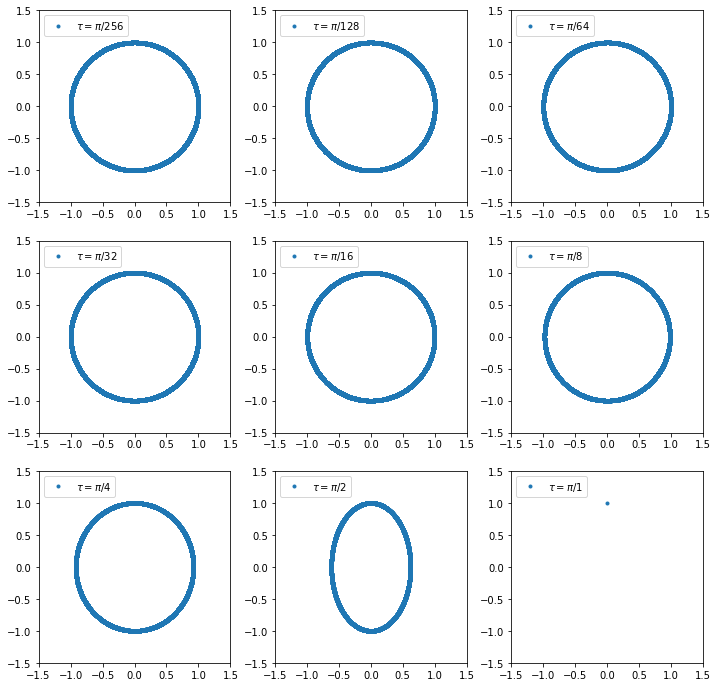

In [10]:
tf = 10000
p0, q0, s0 = 0, 0., 1.
epsilon = 0
vdp = vanDerPol(epsilon, 0, 0)
plt.figure(figsize=(12,12))
for fact, spl in [(256,"331"),(128,"332"),(64,"333"),
                (32,"334"),(16,"335"),(8,"336"),
                (4,"337"),(2,"338"),(1,"339")]:
    tspan = np.arange(0, tf, np.pi/fact)
    plt.subplot(spl)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,
             '.',label=r"$\tau = \pi $/" f"${fact}$")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))
    plt.legend(loc='upper left')

plt.show()

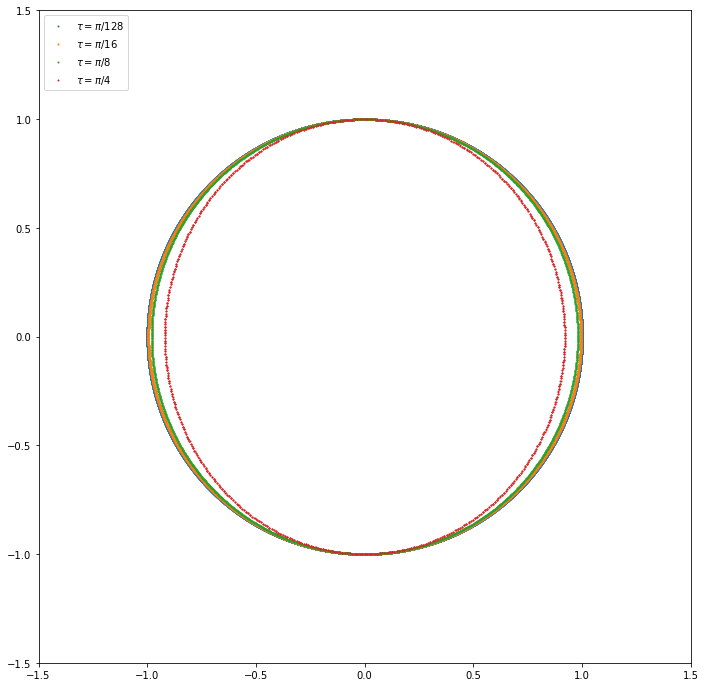

In [8]:
tf = 1000
p0, q0, s0 = 0, 0., 1.
epsilon = 0
vdp = vanDerPol(epsilon, 0, 0)
plt.figure(figsize=(12,12))

for fact in [128,16,8,4]:
    tspan = np.arange(0, tf, np.pi/fact)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,'.',
             label=r"$\tau = \pi $/" f"${fact}$",
             markersize=2)
    
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.legend(loc='upper left')
plt.show()

## Period and frequency vs time step $\epsilon=0$

In [ ]:
#we have to fix the function of the Modified Hamiltonian as O(tau^8)
#and also insert a comparison with the different choice of the modified Hamiltonian.

In [98]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0]
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(0, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/np.pi))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.2831851 , 6.28318416, 6.28318322, 6.28318165, 6.28317882,
       6.28317662, 6.28317316, 6.28316782, 6.28316248, 6.28315839,
       6.28315368, 6.28314645, 6.28314268, 6.28313136, 6.28312854,
       6.28311754, 6.28310811, 6.28309742, 6.28308862, 6.28307982,
       6.28307197, 6.28306034, 6.28304777, 6.28303708, 6.28302168,
       6.28301194, 6.28298994, 6.28298177, 6.28296574, 6.28295412,
       6.2829362 , 6.28292143, 6.28290132, 6.28287304, 6.28286298,
       6.28284852, 6.28282558, 6.28280201, 6.28278724, 6.28276556,
       6.28274104, 6.28272219, 6.28268919, 6.28268008, 6.28264771,
       6.28264299, 6.28260905, 6.28258454, 6.2825638 , 6.28252671,
       6.2825044 , 6.28247266, 6.28244877, 6.28242992, 6.28239315,
       6.28236907, 6.2823282 , 6.28228796, 6.28228513, 6.28225086,
       6.28221377, 6.28219239, 6.28213581, 6.28209997, 6.28207325,
       6.28203395, 6.28201352, 6.28197296, 6.28195002, 6.28191135,
       6.28185948, 6.2818303 , 6.28178536, 6.28174419, 6.28170

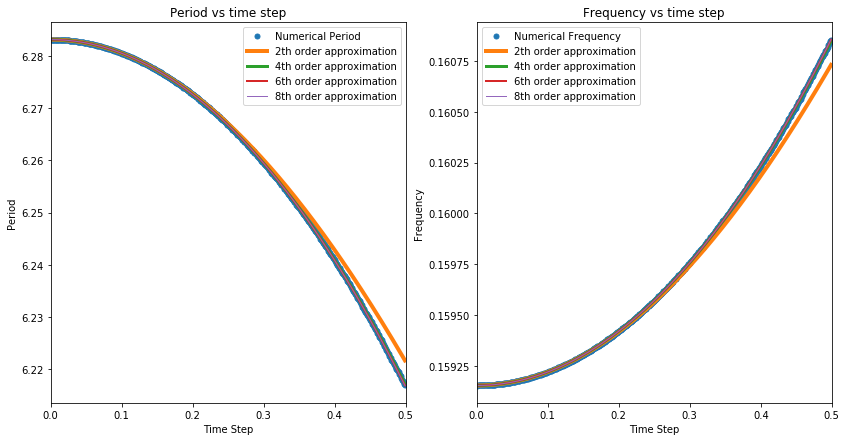

In [100]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2)*
                       (1260 + 210*dt**2))/(5040.*np.pi)),
         label="2th order approximation",linewidth=4)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4)*
                       (1260 + 210*dt**2 + 42*dt**4))/(5040.*np.pi)),
         label="4th order approximation",linewidth=3)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6)*
                       (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6))/(5040.*np.pi)),
         label="6th order approximation",linewidth=2)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                       (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi)),
         label="8th order approximation",linewidth=1)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,np.sqrt((5040 - 420*dt**2)*
                    (1260 + 210*dt**2))/(5040.*np.pi),
        label="2th order approximation",linewidth=4)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4)*
                    (1260 + 210*dt**2 + 42*dt**4))/(5040.*np.pi),
        label="4th order approximation",linewidth=3)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6)*
                    (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6))/(5040.*np.pi),
        label="6th order approximation",linewidth=2)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                    (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi),
        label="8th order approximation",linewidth=1)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

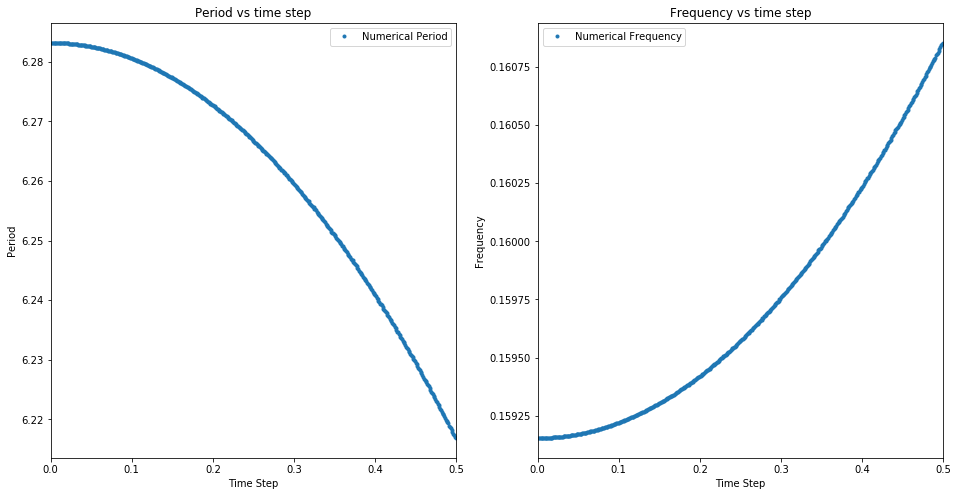

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## Orbits $\epsilon \sim 1$

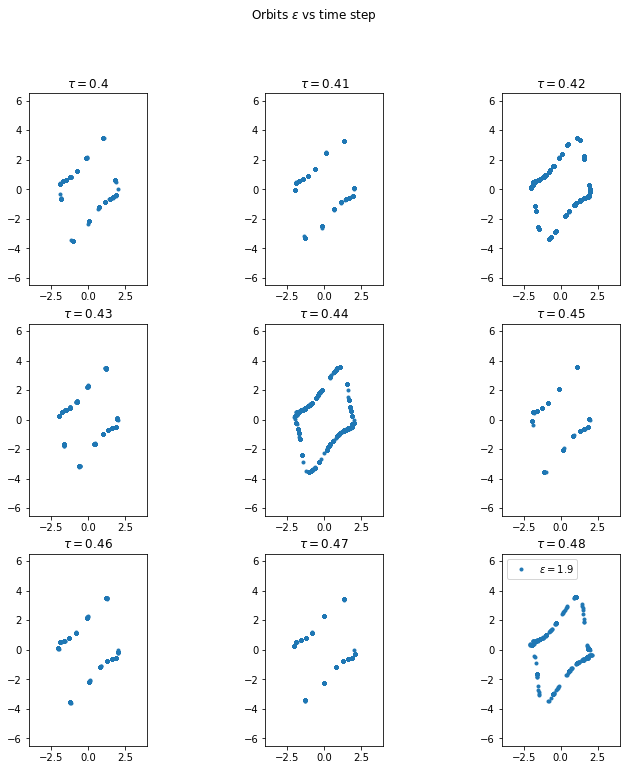

In [34]:
tf = 100000
p0, q0, s0 = 0, 2, 0
plt.figure(figsize=(12,12))
plt.suptitle(r"Orbits $\epsilon$ vs time step")
steps=[(0.4,"331"),(0.41,"332"),(0.42,"333"),
                (0.43,"334"),(0.44,"335"),(0.45,"336"),
                (0.46,"337"),(0.47,"338"),(0.48,"339")]
for fact, spl in steps:
    vdp = vanDerPol(1.5, 0, 0)
    tspan = np.arange(0, tf, fact)
    plt.subplot(spl)
    plt.gca().set_title(r"$\tau = " f"${fact}")
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,'.',
             label=r"$\epsilon = $" f"${epsilon}$")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-4,4))
    plt.ylim((-6.5,6.5))


plt.legend(loc='upper left')
plt.show()

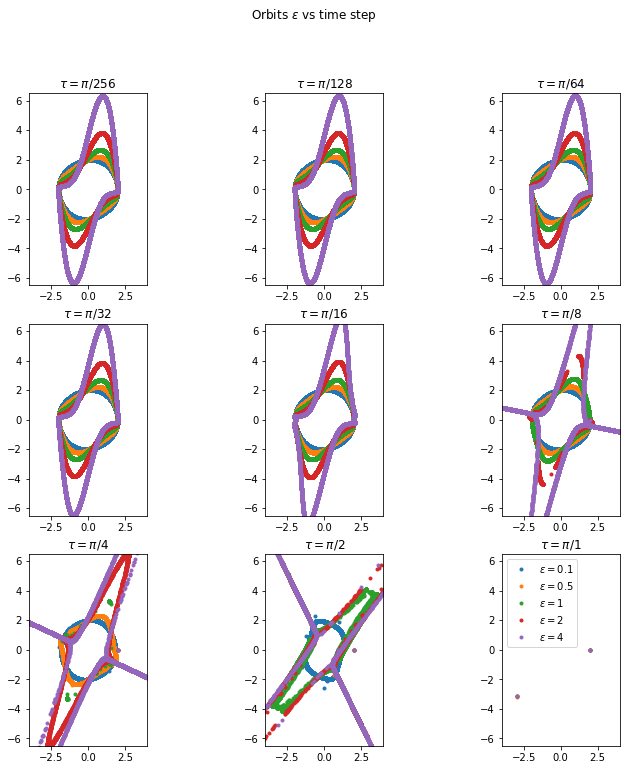

In [13]:
tf = 10000
p0, q0, s0 = 0, 2, 0
plt.figure(figsize=(12,12))
elist=[0.1,0.5,1,2,4]
plt.suptitle(r"Orbits $\epsilon$ vs time step")
steps=[(256,"331"),(128,"332"),(64,"333"),
                (32,"334"),(16,"335"),(8,"336"),
                (4,"337"),(2,"338"),(1,"339")]
for fact, spl in steps:
    for epsilon in elist:
        vdp = vanDerPol(epsilon, 0, 0)
        tspan = np.arange(0, tf, np.pi/fact)
        plt.subplot(spl)
        plt.gca().set_title(r"$\tau = \pi /" f"${fact}")
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        plt.plot(sol[:,1],sols,'.',
                 label=r"$\epsilon = $" f"${epsilon}$")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim((-4,4))
        plt.ylim((-6.5,6.5))


plt.legend(loc='upper left')
plt.show()

## Period and frequency vs time step $\epsilon\sim1$.

## $\epsilon = 0.1$

In [10]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=0.1
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/3))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.28711101, 6.28711006, 6.28710849, 6.28710692, 6.28710535,
       6.28710189, 6.28709623, 6.28709182, 6.28708868, 6.28708491,
       6.28707767, 6.2870717 , 6.28706572, 6.2870566 , 6.28705189,
       6.28703899, 6.28703302, 6.28702075, 6.28701038, 6.287     ,
       6.28698396, 6.28697736, 6.28697044, 6.28695094, 6.28694182,
       6.28692264, 6.28690755, 6.28688931, 6.28688082, 6.28686792,
       6.28684874, 6.2868327 , 6.28681132, 6.28679245, 6.28677044,
       6.28675472, 6.28674214, 6.28671761, 6.28668962, 6.28666667,
       6.28664088, 6.28662075, 6.2866    , 6.28658994, 6.2865566 ,
       6.28652201, 6.28651604, 6.28647547, 6.28645346, 6.28643082,
       6.28640755, 6.28637484, 6.28633333, 6.28632023, 6.28628028,
       6.28625102, 6.28620887, 6.28618559, 6.2861447 , 6.28610884,
       6.28608934, 6.28604718, 6.28600881, 6.28599182, 6.28596414,
       6.28590311, 6.28588141, 6.28583957, 6.28579365, 6.28575786,
       6.2857327 , 6.28566792, 6.28564434, 6.28560189, 6.28554

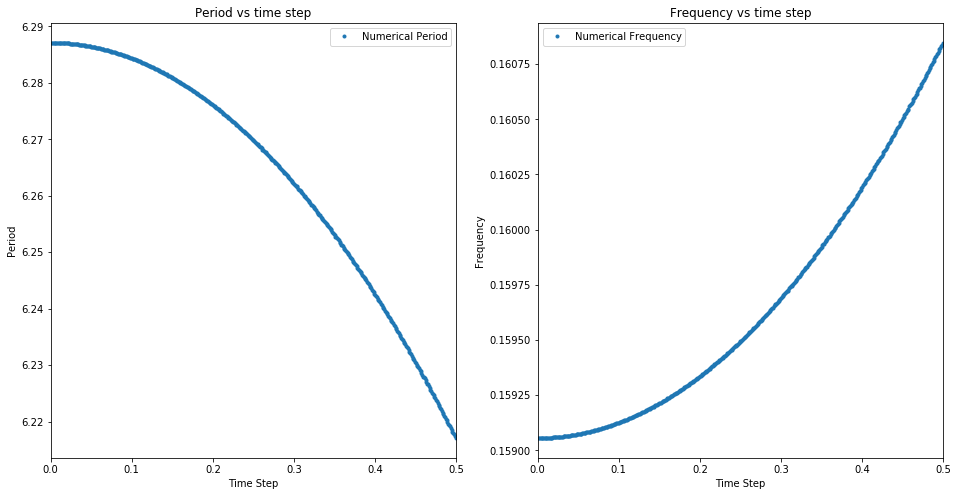

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

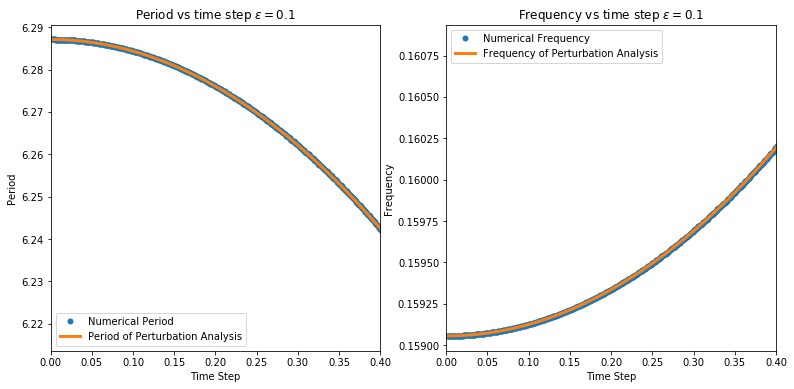

In [13]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.5$  

In [14]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=0.5
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/3))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.38067507, 6.38067348, 6.3806706 , 6.38066518, 6.38066071,
       6.38065432, 6.38064635, 6.38063709, 6.38062656, 6.38061602,
       6.38060038, 6.38059004, 6.38057184, 6.38055364, 6.3805364 ,
       6.38052107, 6.3804984 , 6.38047701, 6.38045115, 6.38042784,
       6.38040613, 6.38037931, 6.38035568, 6.38032184, 6.38028416,
       6.38025223, 6.38022414, 6.38020051, 6.38015741, 6.38012452,
       6.3800811 , 6.38004598, 6.38      , 6.37996105, 6.37992337,
       6.37988254, 6.37982509, 6.37979125, 6.37974274, 6.3796872 ,
       6.37964188, 6.37958953, 6.37953159, 6.37948054, 6.37941768,
       6.37936631, 6.3793277 , 6.37925207, 6.37919336, 6.3791321 ,
       6.37906828, 6.37900957, 6.37894065, 6.37887492, 6.37880664,
       6.37874665, 6.37867103, 6.378612  , 6.3785158 , 6.37846154,
       6.3783843 , 6.37830195, 6.37822215, 6.37816278, 6.37807054,
       6.37800575, 6.37791669, 6.37783153, 6.37774442, 6.37766114,
       6.37756254, 6.37747751, 6.37740574, 6.37731292, 6.37722

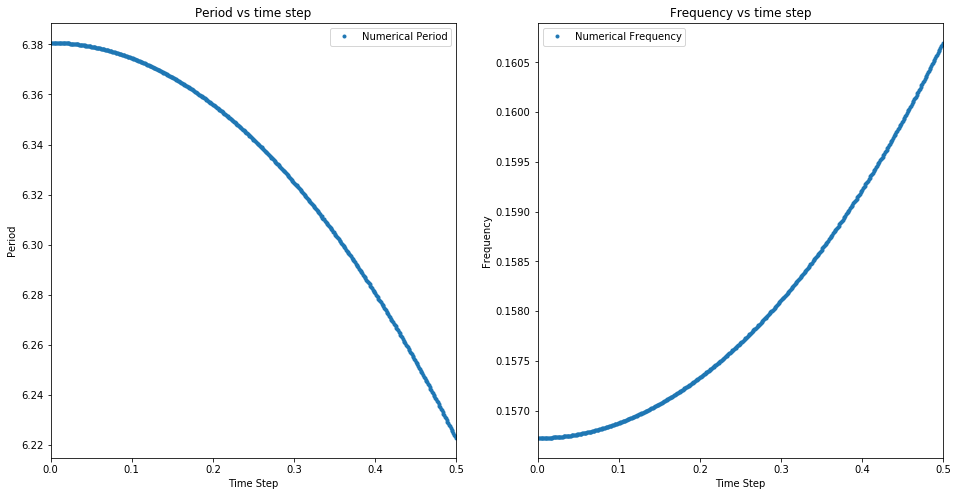

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

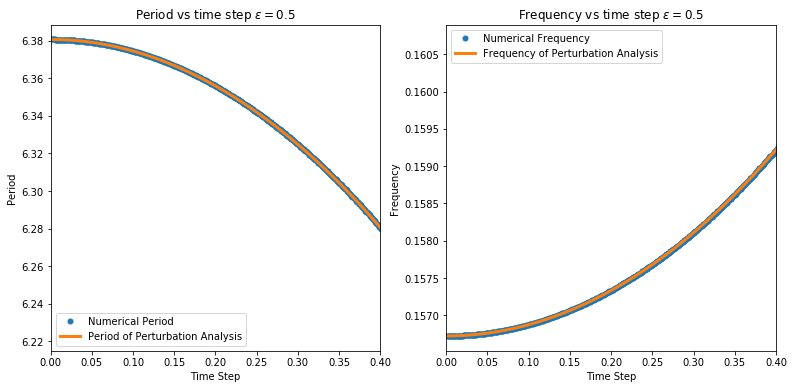

In [16]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.9$

In [17]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=0.9
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/3))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.59323219, 6.59322823, 6.59322032, 6.59320976, 6.59319756,
       6.59318074, 6.59315963, 6.5931372 , 6.59311445, 6.59308377,
       6.59305244, 6.59301617, 6.59297724, 6.59293764, 6.59289838,
       6.59284988, 6.59279743, 6.59275091, 6.59269284, 6.59263609,
       6.59256582, 6.5925094 , 6.59244045, 6.59237479, 6.59229627,
       6.59221768, 6.59214083, 6.59206069, 6.59197164, 6.59187933,
       6.59178767, 6.59169403, 6.59158952, 6.59150478, 6.59138971,
       6.59128783, 6.59117244, 6.59106429, 6.59094857, 6.59083113,
       6.59072296, 6.59059235, 6.5904591 , 6.59032058, 6.5901847 ,
       6.59006135, 6.58991757, 6.58977983, 6.58962788, 6.58948583,
       6.58933784, 6.58917469, 6.5890145 , 6.58885432, 6.58868447,
       6.58852094, 6.58835806, 6.58819189, 6.58800264, 6.58783784,
       6.58765821, 6.58748468, 6.58726755, 6.58710774, 6.58688797,
       6.58669127, 6.58649308, 6.58629532, 6.5861114 , 6.58588332,
       6.58568863, 6.58544975, 6.5852444 , 6.58502503, 6.58480

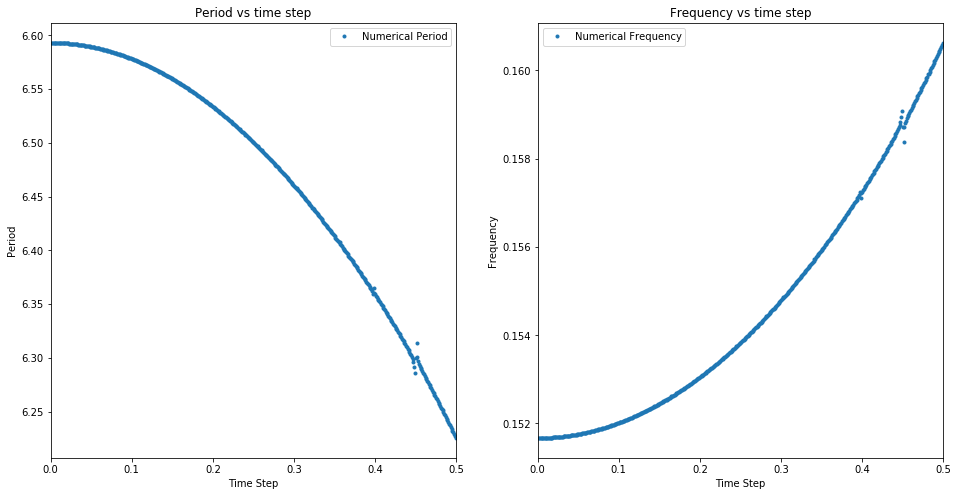

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

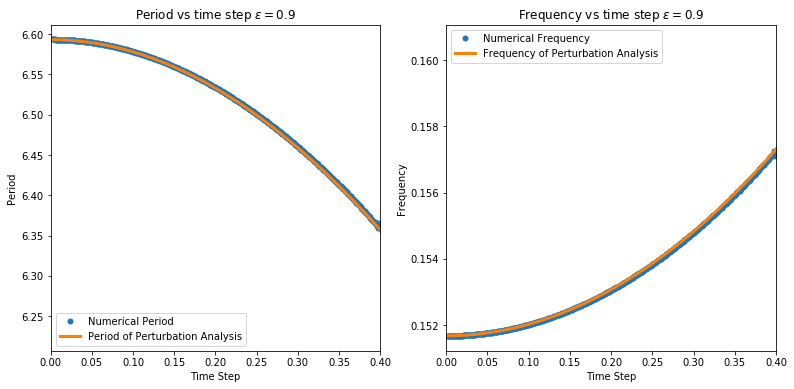

In [19]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 1.1$

In [21]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
epsilon=1.1
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(epsilon, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/np.pi))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.73941956, 6.73941315, 6.73940236, 6.73938752, 6.73936594,
       6.73934165, 6.73931433, 6.73928094, 6.7392425 , 6.73920067,
       6.73915278, 6.73910287, 6.73904654, 6.73899089, 6.7389258 ,
       6.73885464, 6.73878624, 6.738706  , 6.7386261 , 6.73853724,
       6.73845197, 6.73835457, 6.73825581, 6.73815167, 6.73804348,
       6.73793461, 6.73781496, 6.73769464, 6.7375787 , 6.73744186,
       6.73730546, 6.73716521, 6.73701787, 6.73687188, 6.73672117,
       6.73656372, 6.73641928, 6.73624259, 6.73608053, 6.73590296,
       6.73571429, 6.73553774, 6.7353531 , 6.73515768, 6.73496967,
       6.73477519, 6.73457567, 6.73434985, 6.73414858, 6.73391714,
       6.73370057, 6.73348333, 6.73324924, 6.73301246, 6.7327746 ,
       6.7325283 , 6.73227999, 6.73202561, 6.73176288, 6.73149495,
       6.73123704, 6.73096633, 6.73069091, 6.73041159, 6.73013809,
       6.72984372, 6.72955219, 6.72927634, 6.72895153, 6.72864692,
       6.72836722, 6.72802424, 6.72772424, 6.72739953, 6.72706

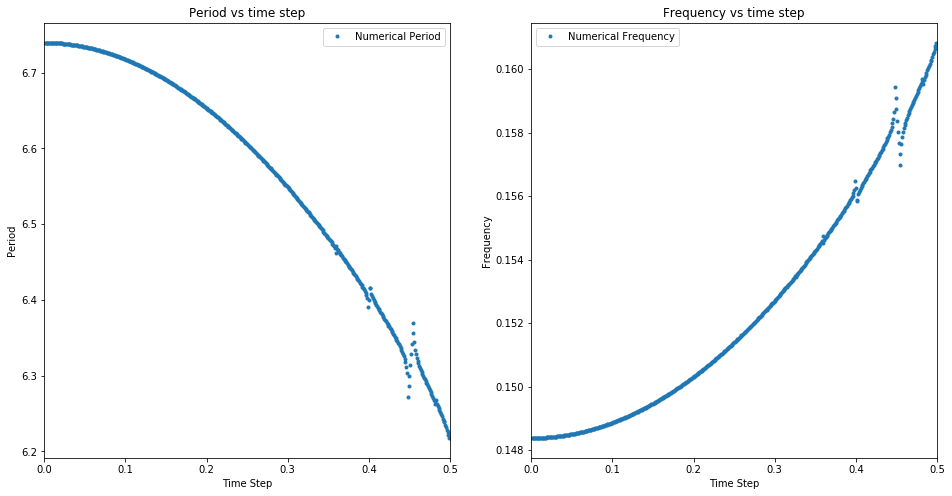

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

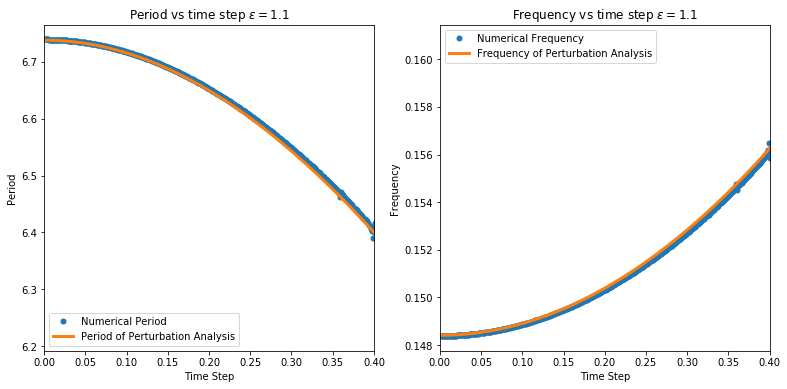

In [23]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(omega(dt,epsilon)),
         label="Period of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,omega(dt,epsilon),
         label="Frequency of Perturbation Analysis",
         linewidth=3)
plt.xlim((0,0.4))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.xlim((0,0.4))
plt.legend(loc='upper left')
plt.show()

## too long things

In [9]:
tf = 10000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0.1,0.3,
       0.5,0.7,
       0.9,1.1,
       1.3,1.5,
       1.7,1.9]
dt=np.arange(0.001,0.5,0.001)
T=np.zeros((len(dt),len(elist)))
k=-1

for epsilon in elist:
    k+=1
    for factor in range(len(dt)):
        t=np.zeros(int(tf))
        tspan = np.arange(0, tf, dt[factor])
        vdp = vanDerPol(epsilon, 0, 0)
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        maxi=np.zeros(5000)
        ns=int(tf/dt[factor])-1
        j=0
        for i in range(ns):
            if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
                maxi[j]=tspan[i]
                j+=1
        for i in range(1,j-1):
            t[i]=(maxi[i+1]-maxi[i])
            T[factor,k]+=t[i]
        T[factor,k]=T[factor,k]/(j-2)

T[T != 0]    

KeyboardInterrupt: 

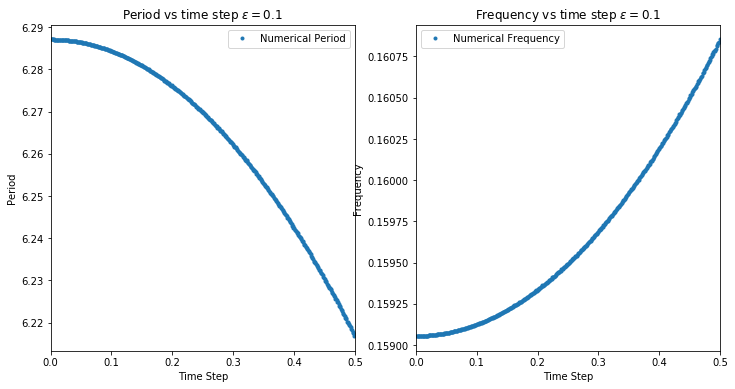

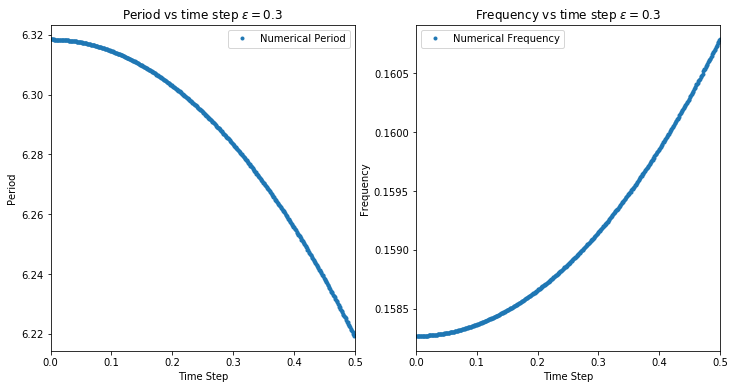

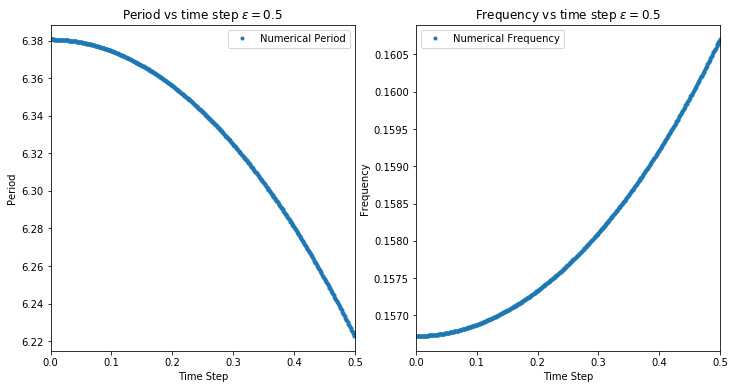

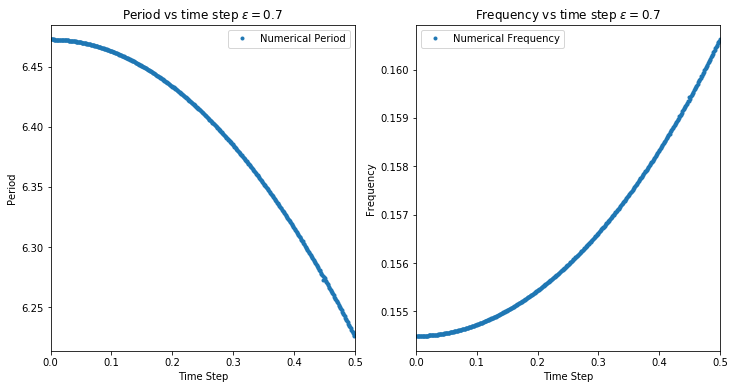

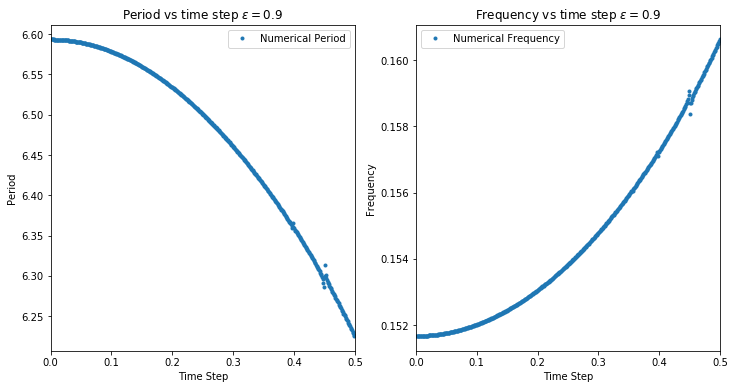

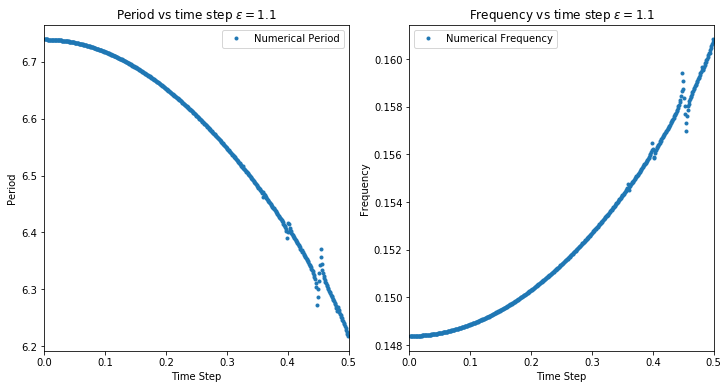

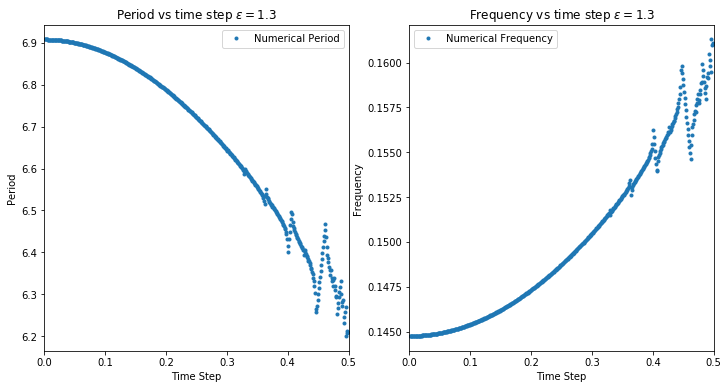

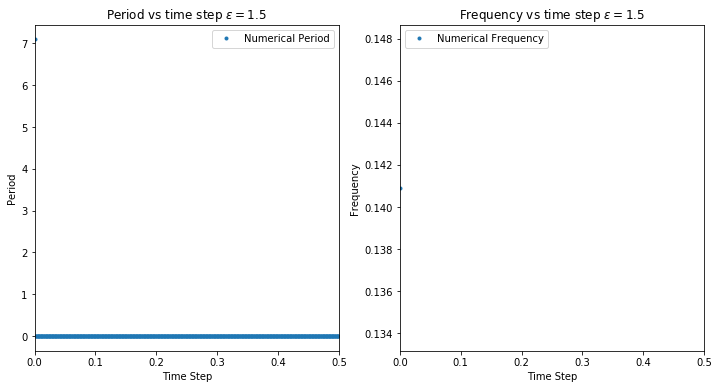

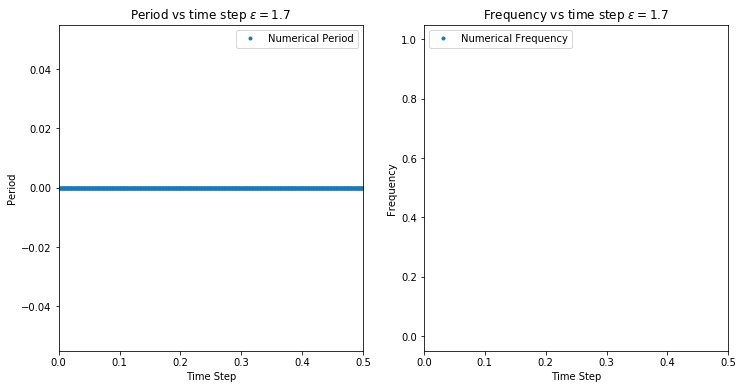

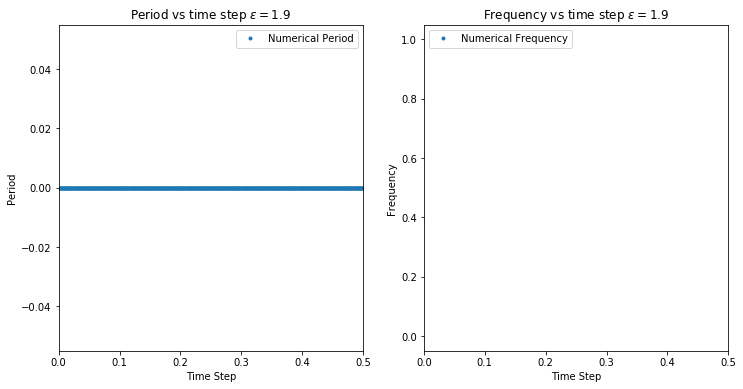

In [35]:
elist=[0.1,0.3,
       0.5,0.7,
       0.9,1.1,
       1.3,1.5,
       1.7,1.9]
for i in range(len(elist)):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${elist[i]}")
    plt.plot(dt,T[:,i],'.',label="Numerical Period")
    plt.xlim((0,0.5))
    plt.ylabel("Period")
    plt.xlabel("Time Step")
    plt.legend(loc='bottom left')

    plt.subplot(122)
    plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${elist[i]}")
    plt.plot(dt,1/T[:,i],'.',label="Numerical Frequency")
    plt.xlim((0,0.5))
    plt.ylabel("Frequency")
    plt.xlabel("Time Step")
    plt.legend(loc='upper left')
    plt.show()

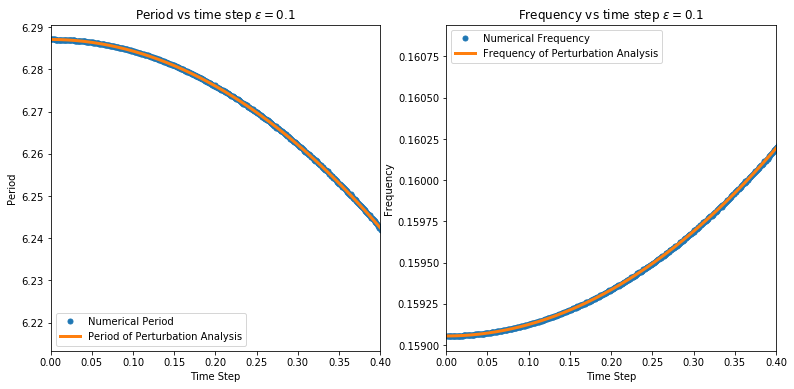

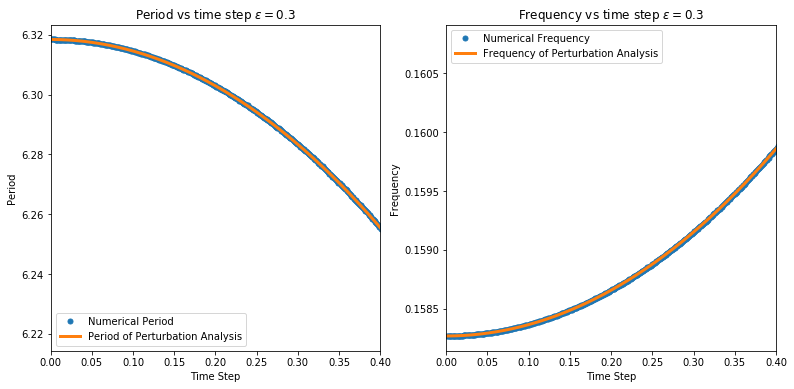

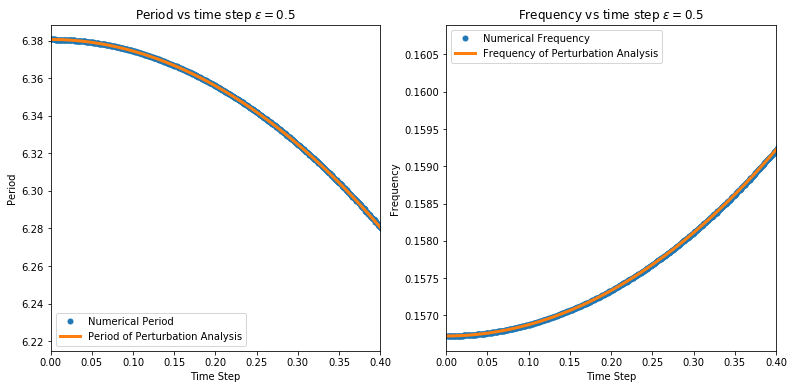

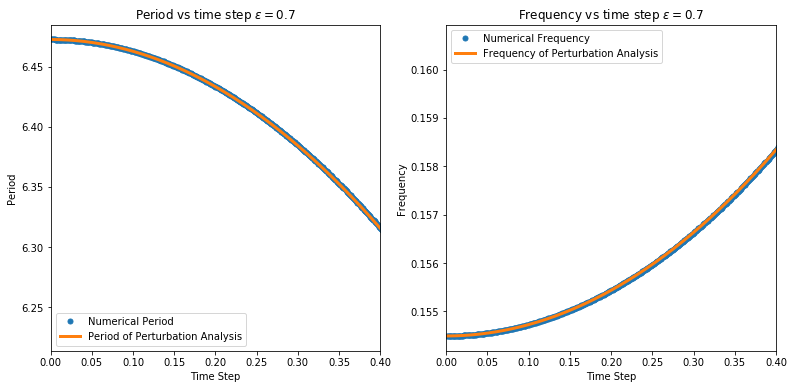

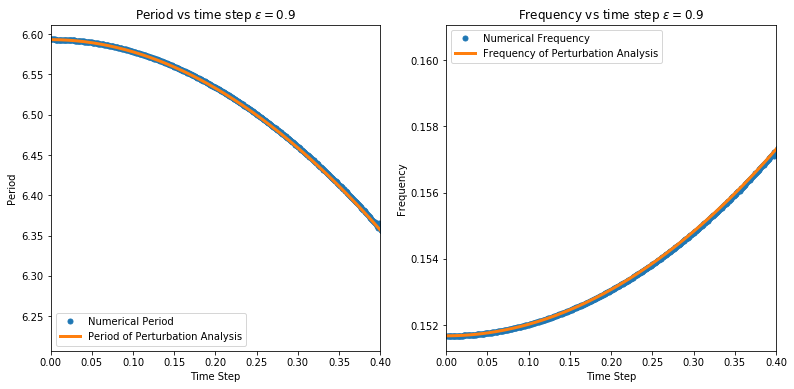

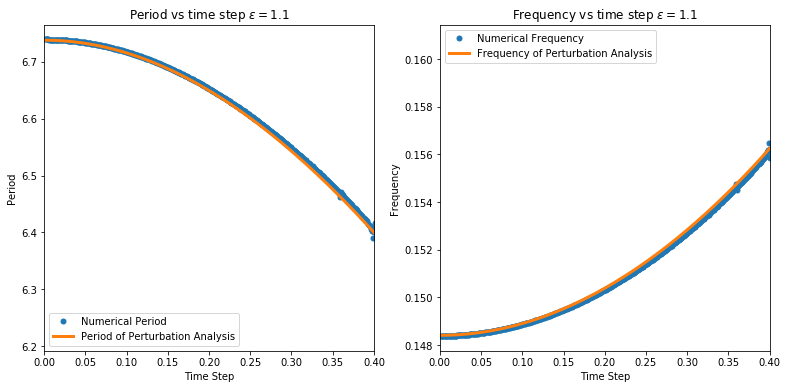

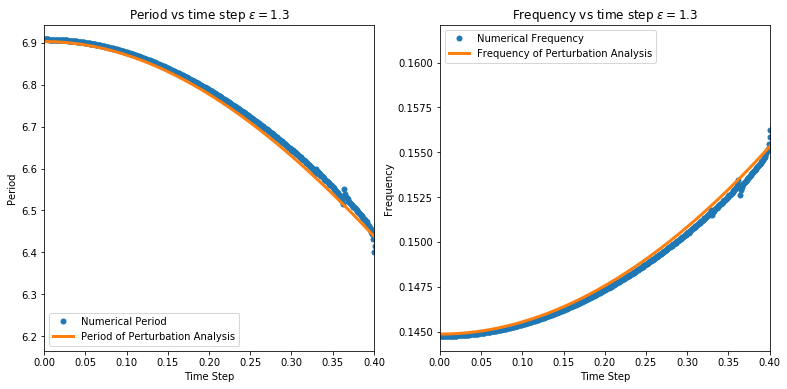

In [38]:
for i in range(len(elist)-3):
    plt.figure(figsize=(13,6))
    epsilon=elist[i]
    plt.subplot(121)
    plt.gca().set_title("Period vs time step " r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,T[:,i],'.',label="Numerical Period",markersize=10)
    plt.plot(dt,1/(omega(dt,epsilon)),
             label="Period of Perturbation Analysis",
             linewidth=3)
    plt.xlim((0,0.4))
    plt.ylabel("Period")
    plt.xlabel("Time Step")
    plt.legend(loc='lower left')

    plt.subplot(122)
    plt.gca().set_title("Frequency vs time step " r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,1/T[:,i],'.',label="Numerical Frequency",markersize=10)
    plt.plot(dt,omega(dt,epsilon),
             label="Frequency of Perturbation Analysis",
             linewidth=3)
    plt.xlim((0,0.4))
    plt.ylabel("Frequency")
    plt.xlabel("Time Step")
    plt.xlim((0,0.4))
    plt.legend(loc='upper left')
    plt.show()

## Orbits for $\epsilon \gg 1$

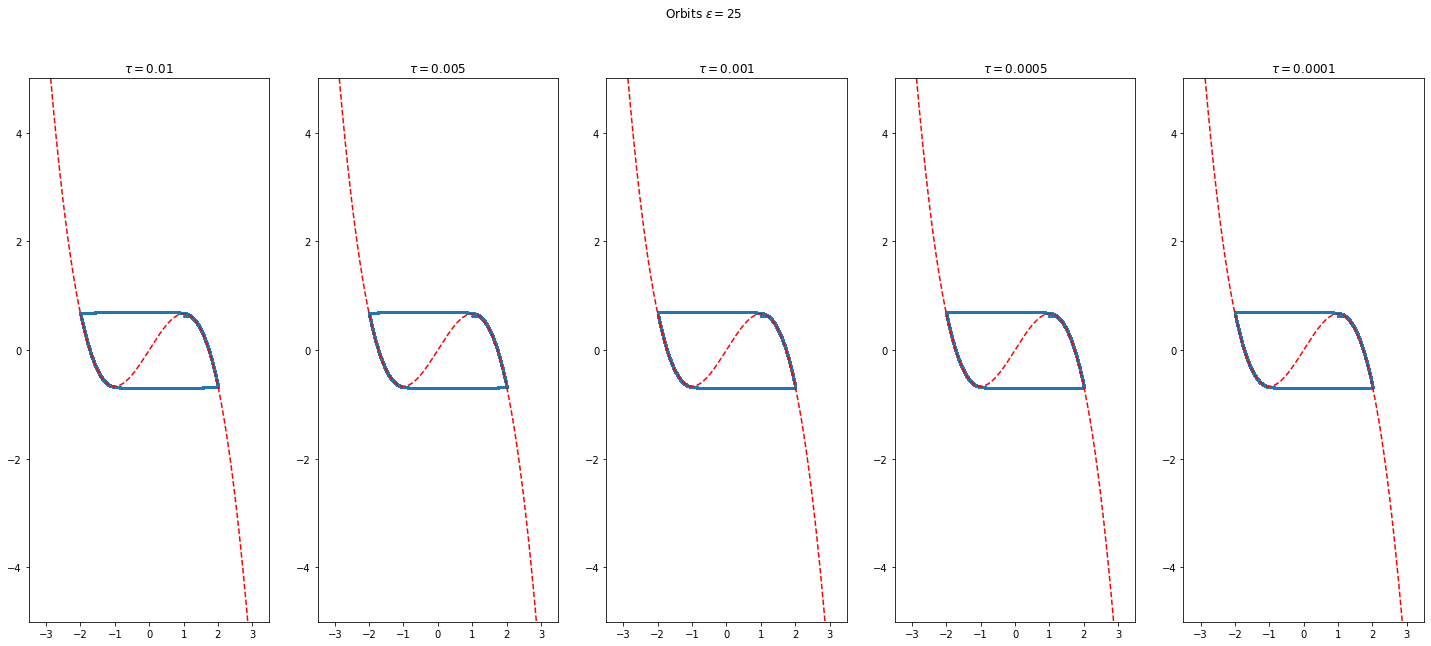

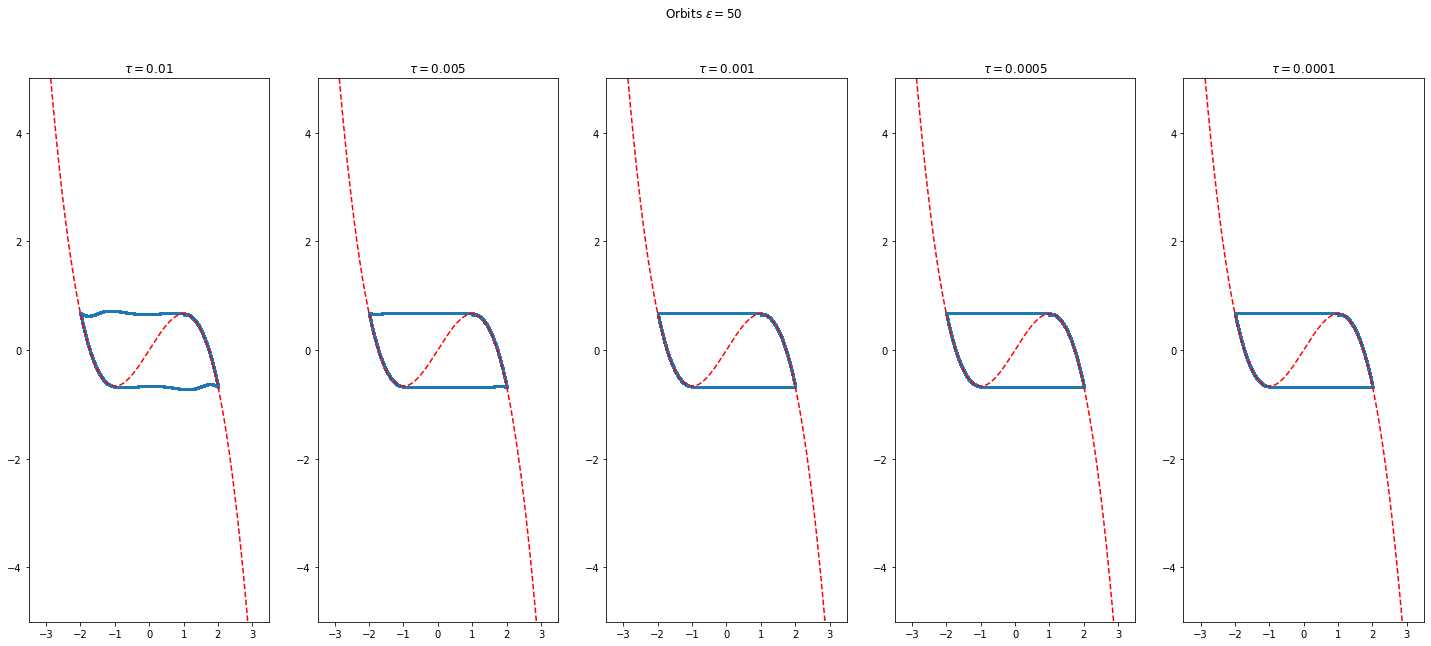

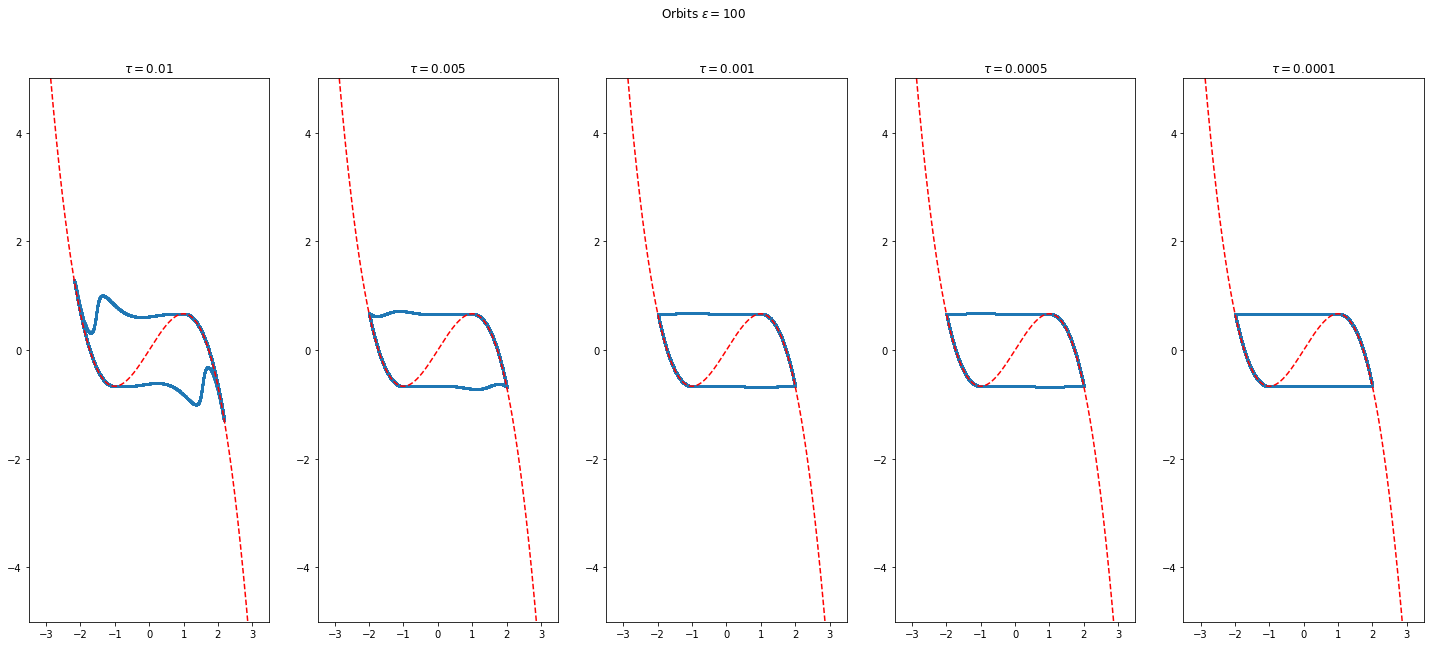

In [13]:
tf = 10000
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
for epsilon in elist:
    vdp = vanDerPol(epsilon, 0, 0)
    plt.figure(figsize=(15,10))
    plt.suptitle(r"Orbits $\epsilon =$" f"{epsilon}")
    for dt, spl in [(0.01,"151"),(0.005,"152"),(0.001,"153"),(0.0005,"154"),(0.0001,"155")]: 
        tspan = np.arange(0, dt*10**7, dt)
        plt.subplot(spl)
        plt.gca().set_title(r"$\tau = " f"${dt}")
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/epsilon),
                 '.',markersize=3)
        plt.plot(x, x-(1/3)*(x)**3,'r--')
        plt.xlim((-3,3))
        plt.ylim((-2,2))
    plt.show()

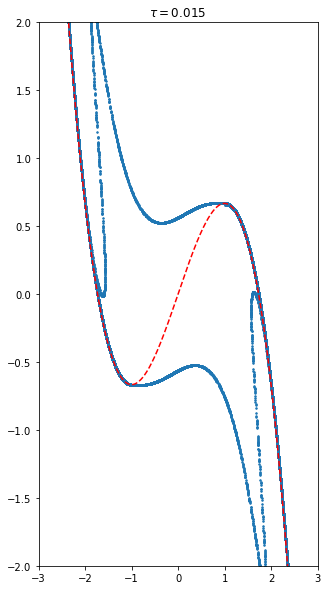

In [46]:
tf = 10000
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
vdp = vanDerPol(100, 0, 0)
#equilibria=[[-0.676854, -3.0209],
#            [0.676854, 3.0209],
#            [0.061395, -2.13541],
#            [-0.061395, 2.13541],
#            [1.1979, -0.681717],
#            [-1.1979, 0.681717],
#            [2.16386, -1.76074],
#            [-2.16386, 1.76074],
#            [-3.4586, 10.3532],
#            [3.11244, -6.93838],
#            [-3.11244, 6.93838],
#            [2.4928, -2.67054],
#            [-2.4928, 2.67054],
#            [0, 0]]
plt.figure(figsize=(5,10))
dt=0.015
tspan = np.arange(0, dt*10**7, dt)
plt.gca().set_title(r"$\tau = " f"${dt}")
sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/100),
        '.',markersize=3)
plt.plot(x, x-(1/3)*(x)**3,'r--')
#for i in range(len(equilibria)):
#    plt.scatter(equilibria[i][0],equilibria[i][1])
plt.xlim((-3,3))
plt.ylim((-2,2))
plt.show()

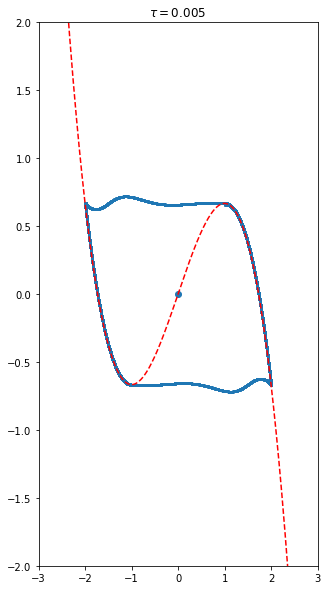

In [36]:
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
vdp = vanDerPol(100, 0, 0)
equilibria=[[-1.43698, 3.66647],
            [1.43698, -3.66647],
            [-2.90115, 6.85665],
            [2.90115, -6.85665],
            [-4.82125, 32.5991], 
            [4.82125, -32.5991],
            [-4.28169, 21.8838],
            [4.28169, -21.8838],
            [-3.38129, 9.50492],
            [3.38129, -9.50492],
            [0, 0]]
plt.figure(figsize=(5,10))
dt=0.005
tspan = np.arange(0, dt*10**7, dt)
plt.gca().set_title(r"$\tau = " f"${dt}")
sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/100),
        '.',markersize=3)
plt.plot(x, x-(1/3)*(x)**3,'r--')
for i in range(len(equilibria)):
    plt.scatter(equilibria[i][0],equilibria[i][1])
plt.xlim((-3,3))
plt.ylim((-2,2))
plt.show()

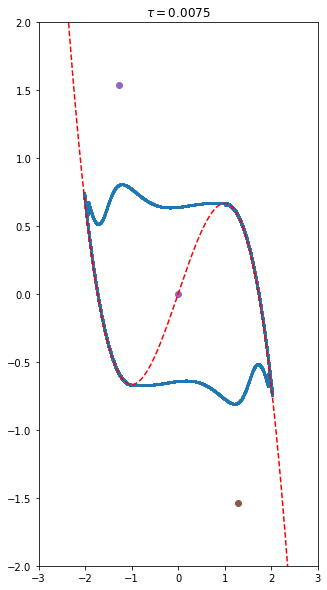

In [37]:
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
vdp = vanDerPol(100, 0, 0)
equilibria=[[-0.0960247, -3.84123],
            [0.0960247, 3.84123], 
            [-0.660755, -4.2436],
            [0.660755, 4.2436],
            [-1.28065, 1.53871],
            [1.28065, -1.53871],
            [-2.43442, 3.23595],
            [2.43442, -3.23595],
            [3.96746, -16.8836],
            [3.5449, -11.3043], 
            [-2.8203, 4.65723],
            [-2.8203, 4.65723],
            [-2.8203, 4.65723],
            [2.8203, -4.65723],
            [0, 0]]
plt.figure(figsize=(5,10))
dt=0.0075
tspan = np.arange(0, dt*10**7, dt)
plt.gca().set_title(r"$\tau = " f"${dt}")
sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/100),
        '.',markersize=3)
plt.plot(x, x-(1/3)*(x)**3,'r--')
for i in range(len(equilibria)):
    plt.scatter(equilibria[i][0],equilibria[i][1])
plt.xlim((-3,3))
plt.ylim((-2,2))
plt.show()

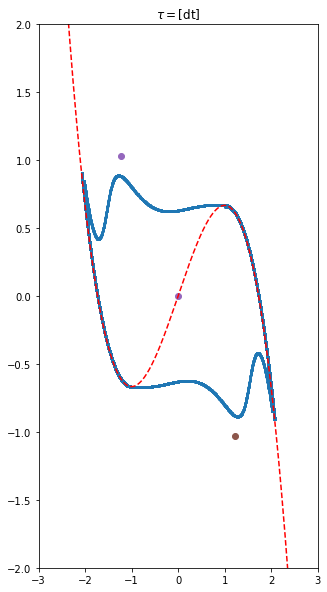

In [38]:
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
vdp = vanDerPol(100, 0, 0)
equilibria=[[-0.673758, -3.51182],
            [0.673758,   3.51182],
            [-0.00921169, -2.83614],
            [0.00921169, 2.83614],
            [-1.23366,1.03007],
            [1.23366, -1.03007],
            [2.28371, -2.36238],
            [-2.28371, 2.36238],
            [-3.68582, 13.0317], 
            [3.68582, -13.0317], 
            [3.30462, -8.72516], 
            [-3.30462, 8.72516], 
            [-2.63815, 3.48212], 
            [2.63815, -3.48212], 
            [0, 0]]
plt.figure(figsize=(5,10))
dt=0.00875
tspan = np.arange(0, dt*10**7, dt)
plt.gca().set_title(r"$\tau = " f"${dt}")
sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/100),
        '.',markersize=3)
plt.plot(x, x-(1/3)*(x)**3,'r--')
for i in range(len(equilibria)):
    plt.scatter(equilibria[i][0],equilibria[i][1])
plt.xlim((-3,3))
plt.ylim((-2,2))
plt.show()

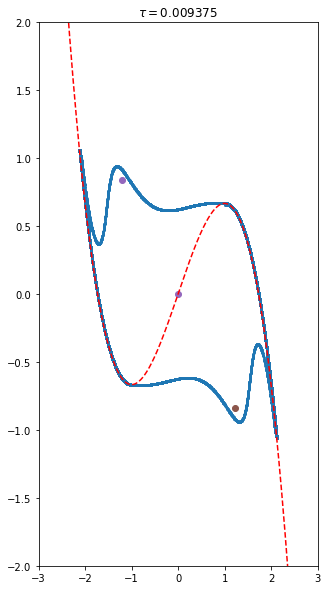

In [39]:
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
vdp = vanDerPol(100, 0, 0)
equilibria=[[-0.676195, -3.24351], [0.676195, 3.24351], [-0.0277025, 
  2.45579], [0.0277025, -2.45579], [-1.21463, 
  0.840595], [1.21463, -0.840595], [2.22059, -2.03555], [-2.22059, 
  2.03555], [-3.56656, 11.5799], [3.20353, -7.75579], [-3.20353, 
  7.75579], [2.56166, -3.04152], [2.56166, -3.04152], [-2.56166, 
  3.04152], [0, 0]]
plt.figure(figsize=(5,10))
dt=0.009375
tspan = np.arange(0, dt*10**7, dt)
plt.gca().set_title(r"$\tau = " f"${dt}")
sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/100),
        '.',markersize=3)
plt.plot(x, x-(1/3)*(x)**3,'r--')
for i in range(len(equilibria)):
    plt.scatter(equilibria[i][0],equilibria[i][1])
plt.xlim((-3,3))
plt.ylim((-2,2))
plt.show()

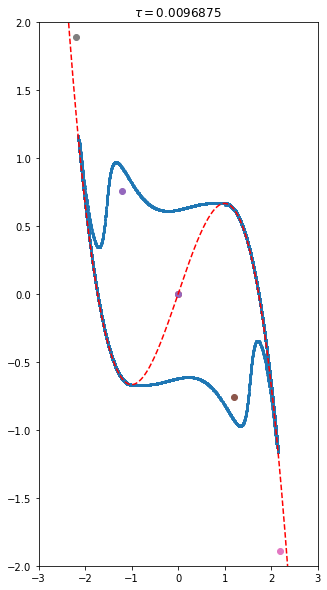

In [40]:
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
vdp = vanDerPol(100, 0, 0)
equilibria=[[-0.676719, -3.12715], [0.676719, 
  3.12715], [0.0449169, -2.2889], [-0.0449169, 2.2889], [-1.206, 
  0.757772], [1.206, -0.757772], [2.19149, -1.89239], [-2.19149, 
  1.89239], [-3.51128, 10.9416], [3.15684, -7.33024], [-3.15684, 
  7.33024], [2.52635, -2.84832], [-2.52635, 2.84832], [0, 0], [0, 0]]
plt.figure(figsize=(5,10))
dt=0.0096875
tspan = np.arange(0, dt*10**7, dt)
plt.gca().set_title(r"$\tau = " f"${dt}")
sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/100),
        '.',markersize=3)
plt.plot(x, x-(1/3)*(x)**3,'r--')
for i in range(len(equilibria)):
    plt.scatter(equilibria[i][0],equilibria[i][1])
plt.xlim((-3,3))
plt.ylim((-2,2))
plt.show()

## Forced Van Der Pol Oscillator

Forced Van der Pol Oscillator from: "Explicit methods in extended phase space for inseparable Hamiltonian problems", 
doi:10.1007/s10569-014-9597-9
$f(q) = - \epsilon (1-q^2)$ and $F(q,t) = q - A \cos(\frac{2 \pi t}{P})$.
Simulations parameters:

$\tau = 0.02$

$t_f = 500$

$\mu = 5$

$A = 5$

$P=\frac{2 \pi}{2.463}$

In [8]:
from scipy import integrate as si

def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

In [8]:
def ivp_vdp(y, t, mu, a, omega):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0] + a*np.cos(omega*t)
    ]

# dt = 0.02
tspan = np.arange(0, 500, 0.02)

y_init, params = [2, 2], (5, 5, 2.463)

y_odeint, info = si.odeint(ivp_vdp, y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 172671, number of Jacobian evaluations: 461


In [32]:
vdp = vanDerPol(5, 5, 2.463)
tspan = np.arange(0, 500, 0.02)

q0, p0, s0 = 2, 0, 2

sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, vdp, tspan, p0, q0, s0)

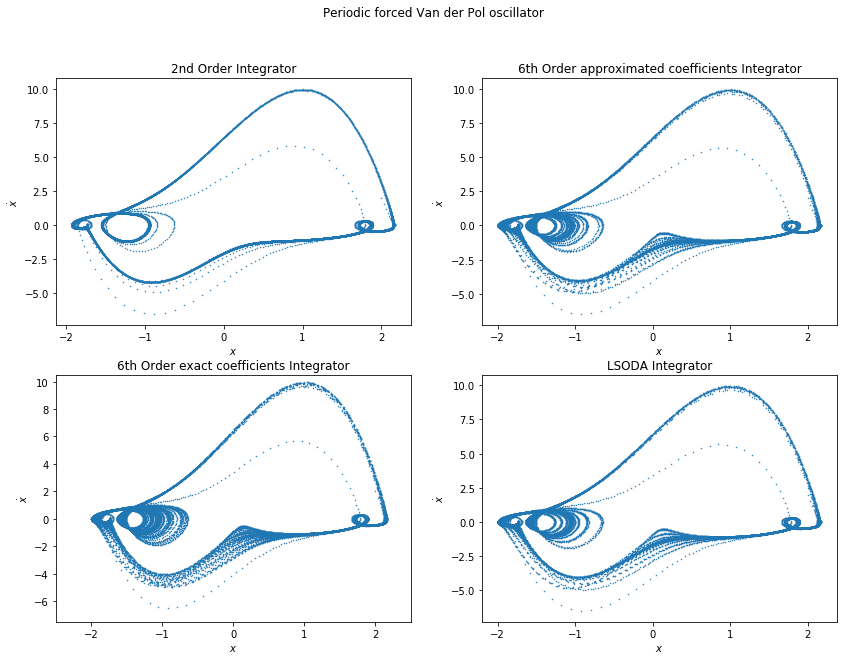

In [36]:
plt.figure(figsize=(14,10))

plt.suptitle("Periodic forced Van der Pol oscillator")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], sols, '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order approximated coefficients Integrator")
plt.plot(solm[:,1], solms,'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order exact coefficients Integrator")
plt.plot(sol1[:,1], sol1s,'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")
plt.xlim((-2.5,2.5))
plt.ylim((-7.5,10.5))

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

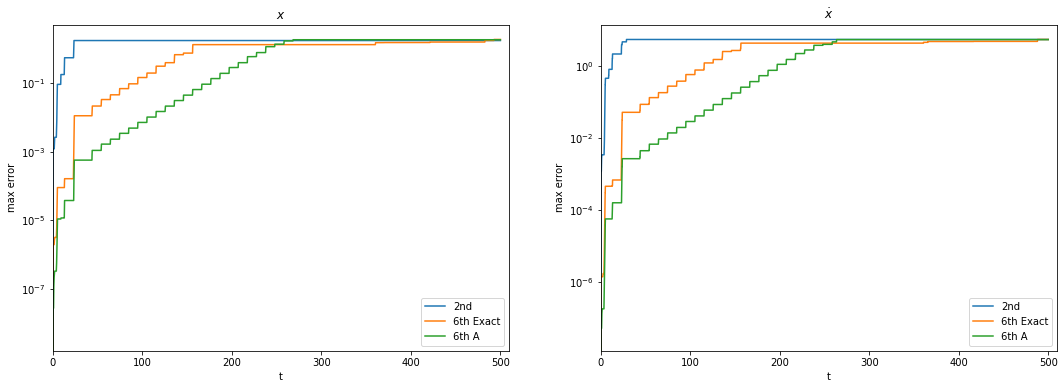

In [37]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
plt.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label='6th Exact')
plt.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label='6th A')
plt.yscale('log')
plt.xlim(0,510)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sols,y_odeint[:,1]),label="2nd")
plt.plot(tspan,
         err(sol1s,y_odeint[:,1]),label="6th Exact")
plt.plot(tspan,
         err(solms,y_odeint[:,1]),label="6th A")
plt.yscale('log')
plt.xlim(0,510)
plt.legend(loc='lower right')

plt.show()

## Fritzhugh - Nagumo model without external current

In [66]:
def fritzhugh(a, b, c):
    def f(q):
        return -(c-c*q**2-b/c)
    def fq(q):
        return +2.0*q
    def F(q,t):
        return -a+(1-b)*q+(b/3.)*q**3
    def Fq(q,t):
        return (+1-b)+b*q**2
    
    return Lienard(f, fq, F, Fq)

def ytras(q,s,c):
    # q -> x
    return s/c-q+(q**3)/3.

def actras(x,y,c):
    return c *(x+y-(x**3)/3.)

In [78]:
a,b,c=0.7,0.8,3.0
trasy= lambda q, s : ytras(q,s,c) #s->y
trass= lambda x, y : actras(x,y,c) #y->s

x0,y0=-0.650,0
q0,p0,s0=x0, 0, trass(x0,y0)

In [86]:
frinag=fritzhugh(a,b,c)
tspan = np.arange(0, 500, 0.05) 

sol, sols, _ = ic.integrate(step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

In [87]:
def ivp_neu(y, t, a, b,c):
    return [
        c*(y[0] + y[1]-(1.0/3.0)*(y[0])**3),
        -(1/c)*(y[0]-a+b*y[1])
    ]

tspan = np.arange(0, 500, 0.05)

y_init, params = [x0, y0], (a,b,c)
y_odeint, info = si.odeint(ivp_neu, y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 1706, number of Jacobian evaluations: 16


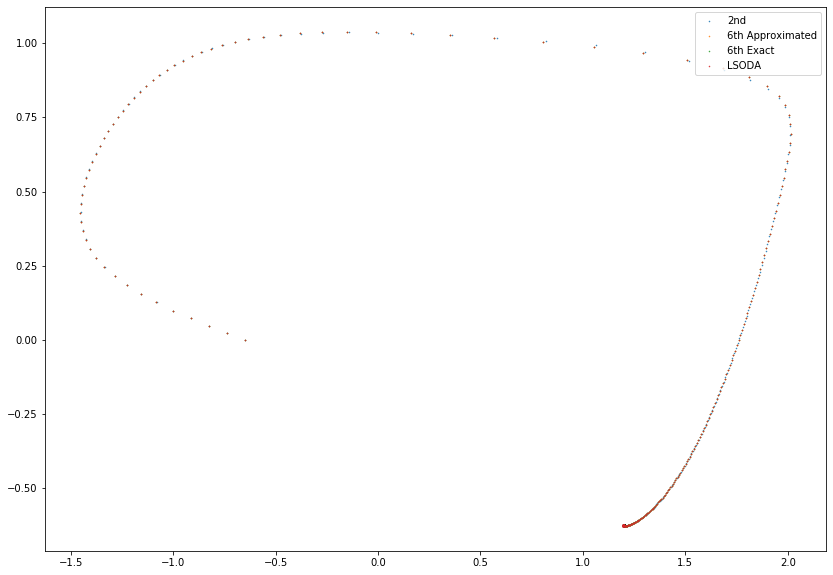

In [88]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], trasy(sol[:,1],sols[:]), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], trasy(solm[:,1],solms[:]),'.',markersize=1,label="6th Approximated")
plt.plot(sol1[:,1], trasy(sol1[:,1],sol1s[:]),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.legend(loc="upper right")
plt.show()

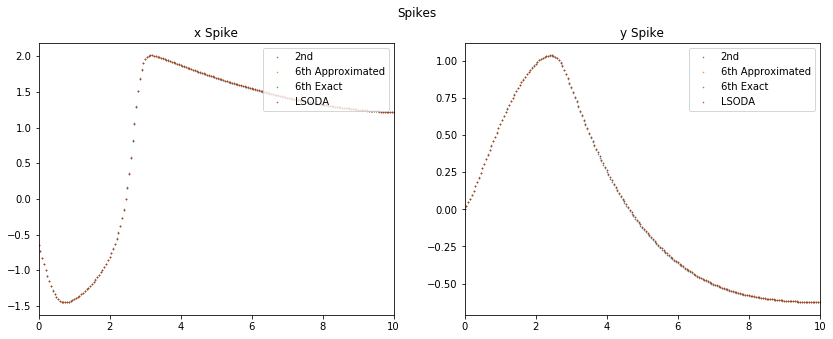

In [89]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th Approximated")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.xlim((0,10))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, trasy(sol[:,1],sols[:]), '.',markersize=1,label="2nd")
plt.plot(tspan, trasy(solm[:,1],solms[:]),'.',markersize=1,label="6th Approximated")
plt.plot(tspan, trasy(sol1[:,1],sol1s[:]),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.xlim((0,10))
plt.legend(loc="upper right")

plt.show()

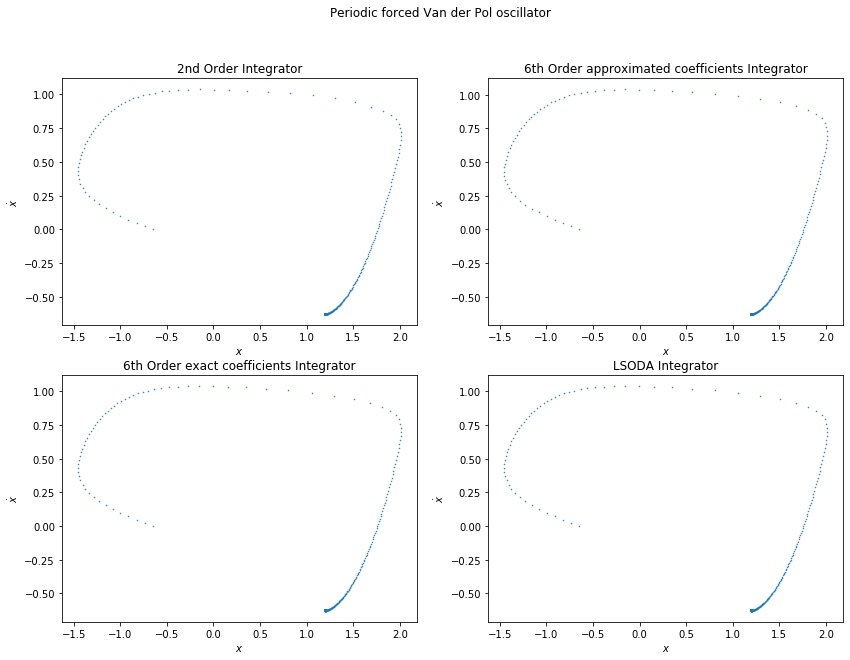

In [90]:
plt.figure(figsize=(14,10))

plt.suptitle("Periodic forced Van der Pol oscillator")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], trasy(sol[:,1],sols[:]), '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order approximated coefficients Integrator")
plt.plot(solm[:,1], trasy(solm[:,1],solms[:]),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order exact coefficients Integrator")
plt.plot(sol1[:,1], trasy(sol1[:,1],sol1s[:]),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

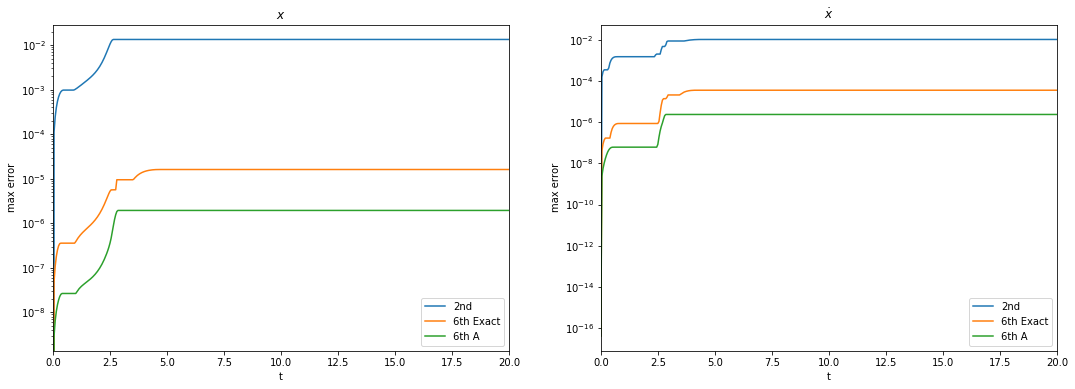

In [91]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
plt.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label='6th Exact')
plt.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label='6th A')
plt.yscale('log')
plt.xlim(0,20)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(trasy(sol[:,1],sols),y_odeint[:,1]),label="2nd")
plt.plot(tspan,
         err(trasy(sol1[:,1],sol1s),y_odeint[:,1]),label="6th Exact")
plt.plot(tspan,
         err(trasy(solm[:,1],solms),y_odeint[:,1]),label="6th A")
plt.yscale('log')
plt.xlim(0,20)
plt.legend(loc='lower right')

plt.show()

## Fritzhugh-Nagumo with stimulation

In [102]:
def stim(t):
    return i0*np.heaviside(t,0)-i0*np.heaviside(t-100,0)

def fritzhugh(a, b, c, i0):        
    def f(q):
        return -(c-c*q**2-b/c)
    def fq(q):
        return +2.0*q
    def F(q,t):
        return -a+(1-b)*q+(b/3.)*q**3-b*stim(t)
    def Fq(q,t):
        return (+1-b)+b*q**2
    
    return Lienard(f, fq, F, Fq)

def ytras(q,s,c,t):
    # q -> x
    return s/c-q+(q**3)/3-stim(t)

def actras(x,y,c,t):
    return c *(x+y-(x**3)/3.+stim(t))

In [103]:
a,b,c,i0=0.7,0.8,3.0,-0.4
frinag=fritzhugh(a,b,c,i0)
trasy= lambda q, s, t : ytras(q,s,c,t) #s->y
trass= lambda x, y, t : actras(x,y,c,t) #y->s

x0,y0=-0.650,0
q0,p0,s0=x0, 0, trass(x0,y0,0)

In [104]:
tspan = np.arange(0, 500, 0.05) 

sol, sols, _ = ic.integrate(step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

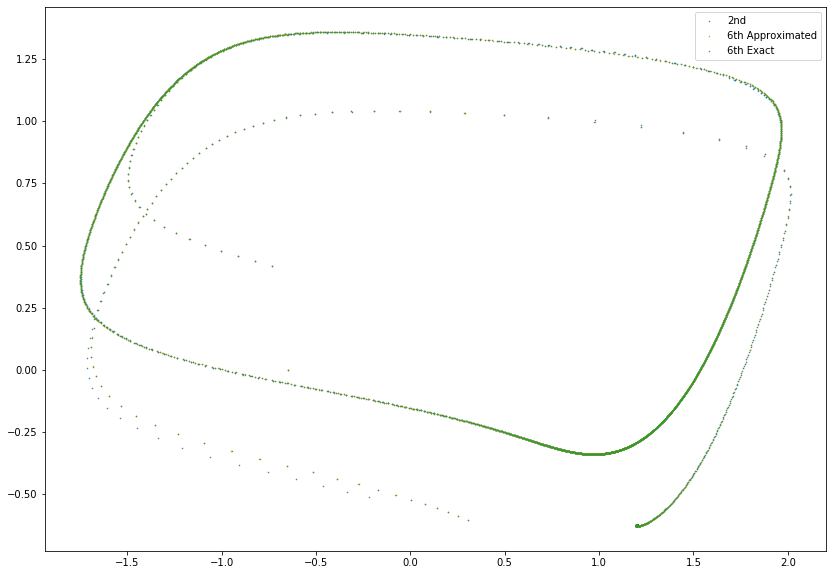

In [105]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], (trasy(sol[:,1],sols[:],tspan[:])), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], (trasy(solm[:,1],solms[:],tspan[:])),'.',markersize=1,label="6th Approximated")
plt.plot(sol1[:,1], (trasy(sol1[:,1],sol1s[:],tspan[:])),'.',markersize=1,label="6th Exact")
plt.legend(loc="upper right")
plt.show()

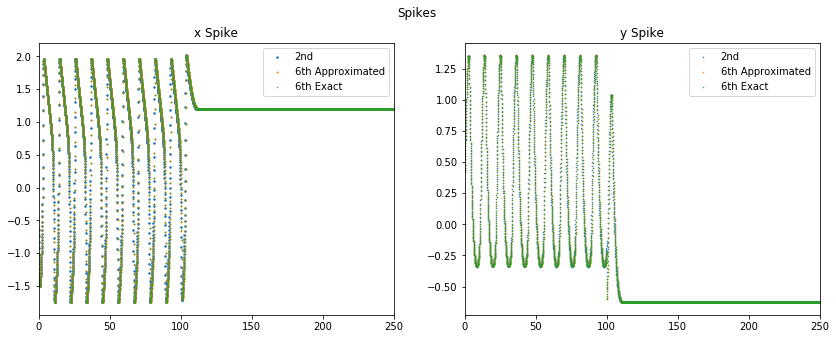

In [106]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=3,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=2,label="6th Approximated")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, trasy(sol[:,1],sols[:],tspan[:]), '.',markersize=1,label="2nd")
plt.plot(tspan, trasy(solm[:,1],solms[:],tspan[:]),'.',markersize=1,label="6th Approximated")
plt.plot(tspan, trasy(sol1[:,1],sol1s[:],tspan[:]),'.',markersize=1,label="6th Exact")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.show()

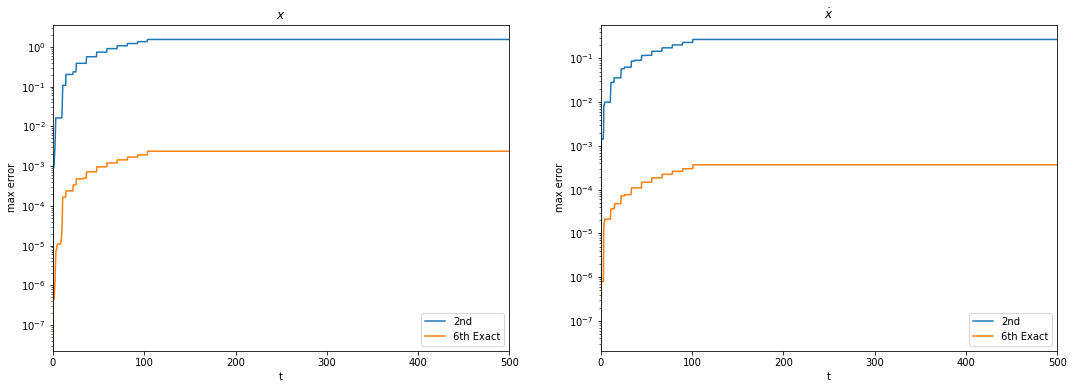

In [107]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],solm[:,1]),label='2nd')
plt.plot(tspan,
         err(sol1[:,1],solm[:,1]),label='6th Exact')
plt.yscale('log')
plt.xlim(0,500)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(trasy(sol[:,1],sols,tspan),trasy(solm[:,1],solms,tspan)),label="2nd")
plt.plot(tspan,
         err(trasy(sol1[:,1],sol1s,tspan),trasy(solm[:,1],solms,tspan)),label="6th Exact")
plt.yscale('log')
plt.xlim(0,500)
plt.legend(loc='lower right')

plt.show()